<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h5><i><center>Sncf delay prediction project</center></i></h5>

<h1>
<hr style=" border:none; height:3px;">
<center>DELAY CAUSES CLASSIFICATION</center>
<hr style=" border:none; height:3px;">
</h1>


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Numpy arrays are used to store training and test data.
import numpy as np

# Pandas is used to manipulate tabular data.
import pandas as pd

# Matplotlib is used to plot graphs.
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Introduction

Ici nous allons traiter un nouveau `Use Case` du projet sur le retard SNCF. Nous avons réussi pour le moment à obtenir un prédiciton du nombre de train en retard pour les mois futurs. Maintenant le but en tant qu'agent de la SNCF serait d'empêcher ces retards. Pour cela, nous pouvons lui fournir un répartition probabiliste de la causes des retard parmis les catégories suivantes : 
+ Retards dus <strong>Externes</strong> -> (<i>Difficilement évitables</i>).
+ Retards liés aux <strong>infrastructures</strong> -> (<i>Possibilité de faire réviser le matériel</i>).
+ Retards liés à la <strong>gestion du traffic</strong> -> (<i>Augmentation de la vigilances pour les opérateurs du traffic</i>).
+ Retards liés au <strong>matériel roulant et son état</strong> -> (<i>Possibilité de faire réviser le matériel</i>).
+ Retards liés à la <strong>gestion de gare</strong> -> (<i>Possibilité d'augmenter ou non les nombres d'agents en gare</i>).
+ Retards liées à la <strong>prise en charge de voyageurs</strong> -> (<i>Difficilement évitables</i>).

Afin de réaliser cette tâche nous allons procédé étape par étape dans notre démarche, en utilisant les différents outils vu dans le cours, afin d'obtenir le meilleur predicteur par rapport à la `RMSE`.

# 1. Exploratory Data Analysis

In [3]:
## Import our main dataset
data_path = "../dataset/regularite-mensuelle-tgv-aqst.csv" 
df_base = pd.read_csv(data_path, sep=",")
df_base.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


## 1.1 Visualisation des causes de retards

Le graphique ci dessous nous permet d'observer la répartition des causes mensuelles moyennes sur tout le réseaux SNCF. Nous observons alors que sur les 6 causes possibles <strong>4 sont résponsables de plus de 80% des retards</strong> : 
+ Retards dus <strong>Externes</strong> -> <i>24.0%</i>.
+ Retards liés aux <strong>infrastructures</strong> -> <i>22.6%</i>.
+ Retards liés à la <strong>gestion du traffic</strong> -> <i>19.6%</i>.
+ Retards liés au <strong>matériel roulant et son état</strong> -> <i>19.6%</i>.

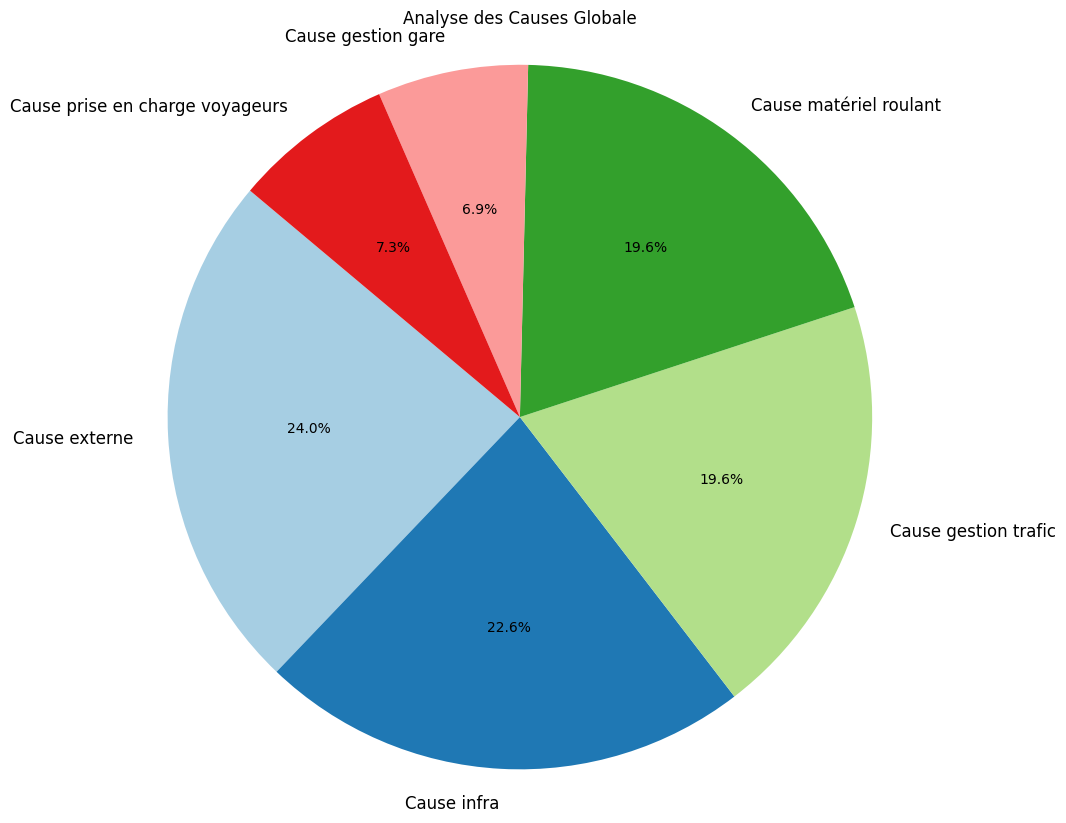

In [5]:
# Données pour le pie chart
causes = ["Cause externe", "Cause infra", "Cause gestion trafic", "Cause matériel roulant", "Cause gestion gare", "Cause prise en charge voyageurs"]
prct_causes = df_base[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean()

# Créer un pie chart
plt.figure(figsize=(10, 10))
plt.pie(prct_causes, labels=causes, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(causes))))

# Titre
plt.title("Analyse des Causes Globale")
plt.axis('equal') 
plt.show()

Afin d'évaluer nos prochains modèles de machine learning une possibilité est de calculer la `RMSE` que nous obtenons si l'on préduit la moyenne à chaque instance (i.e les valeurs ci dessus). Ainsi si nous obtenons des algorithmes avec une `RMSE` supérieur il est inutiles de les conserverser.<br>

In [9]:
from sklearn.metrics import mean_squared_error

prct_causes = df_base[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean()
# Nous créons un DataFrame de prédictions en utilisant la moyenne, en répétant la même moyenne pour chaque ligne
predictions = pd.DataFrame(np.tile(prct_causes.values, (len(df_base), 1)), columns=prct_causes.index)
# Nous prennons ensuite nous valeurs réelles
valeurs_reelles = df_base[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]]

# Calcul de RMSE
rmse = np.sqrt(mean_squared_error(valeurs_reelles, predictions, multioutput='raw_values'))
average_rmse = np.mean(rmse)
print(f"RMSE par colonne: {rmse}")
print(f"RMSE moyenne: {average_rmse}")

RMSE par colonne: [16.80416144 15.69155897 14.94663099 14.25565924  8.08026358 10.24882433]
RMSE moyenne: 13.33784975896364


<div class="alert alert-block alert-success">
<center>Après executions nous obtenons donc qu'il est nécessaire de battre une <strong>RMSE moyenne sur les 6 colonnes de 13.3</strong></center>
</div>


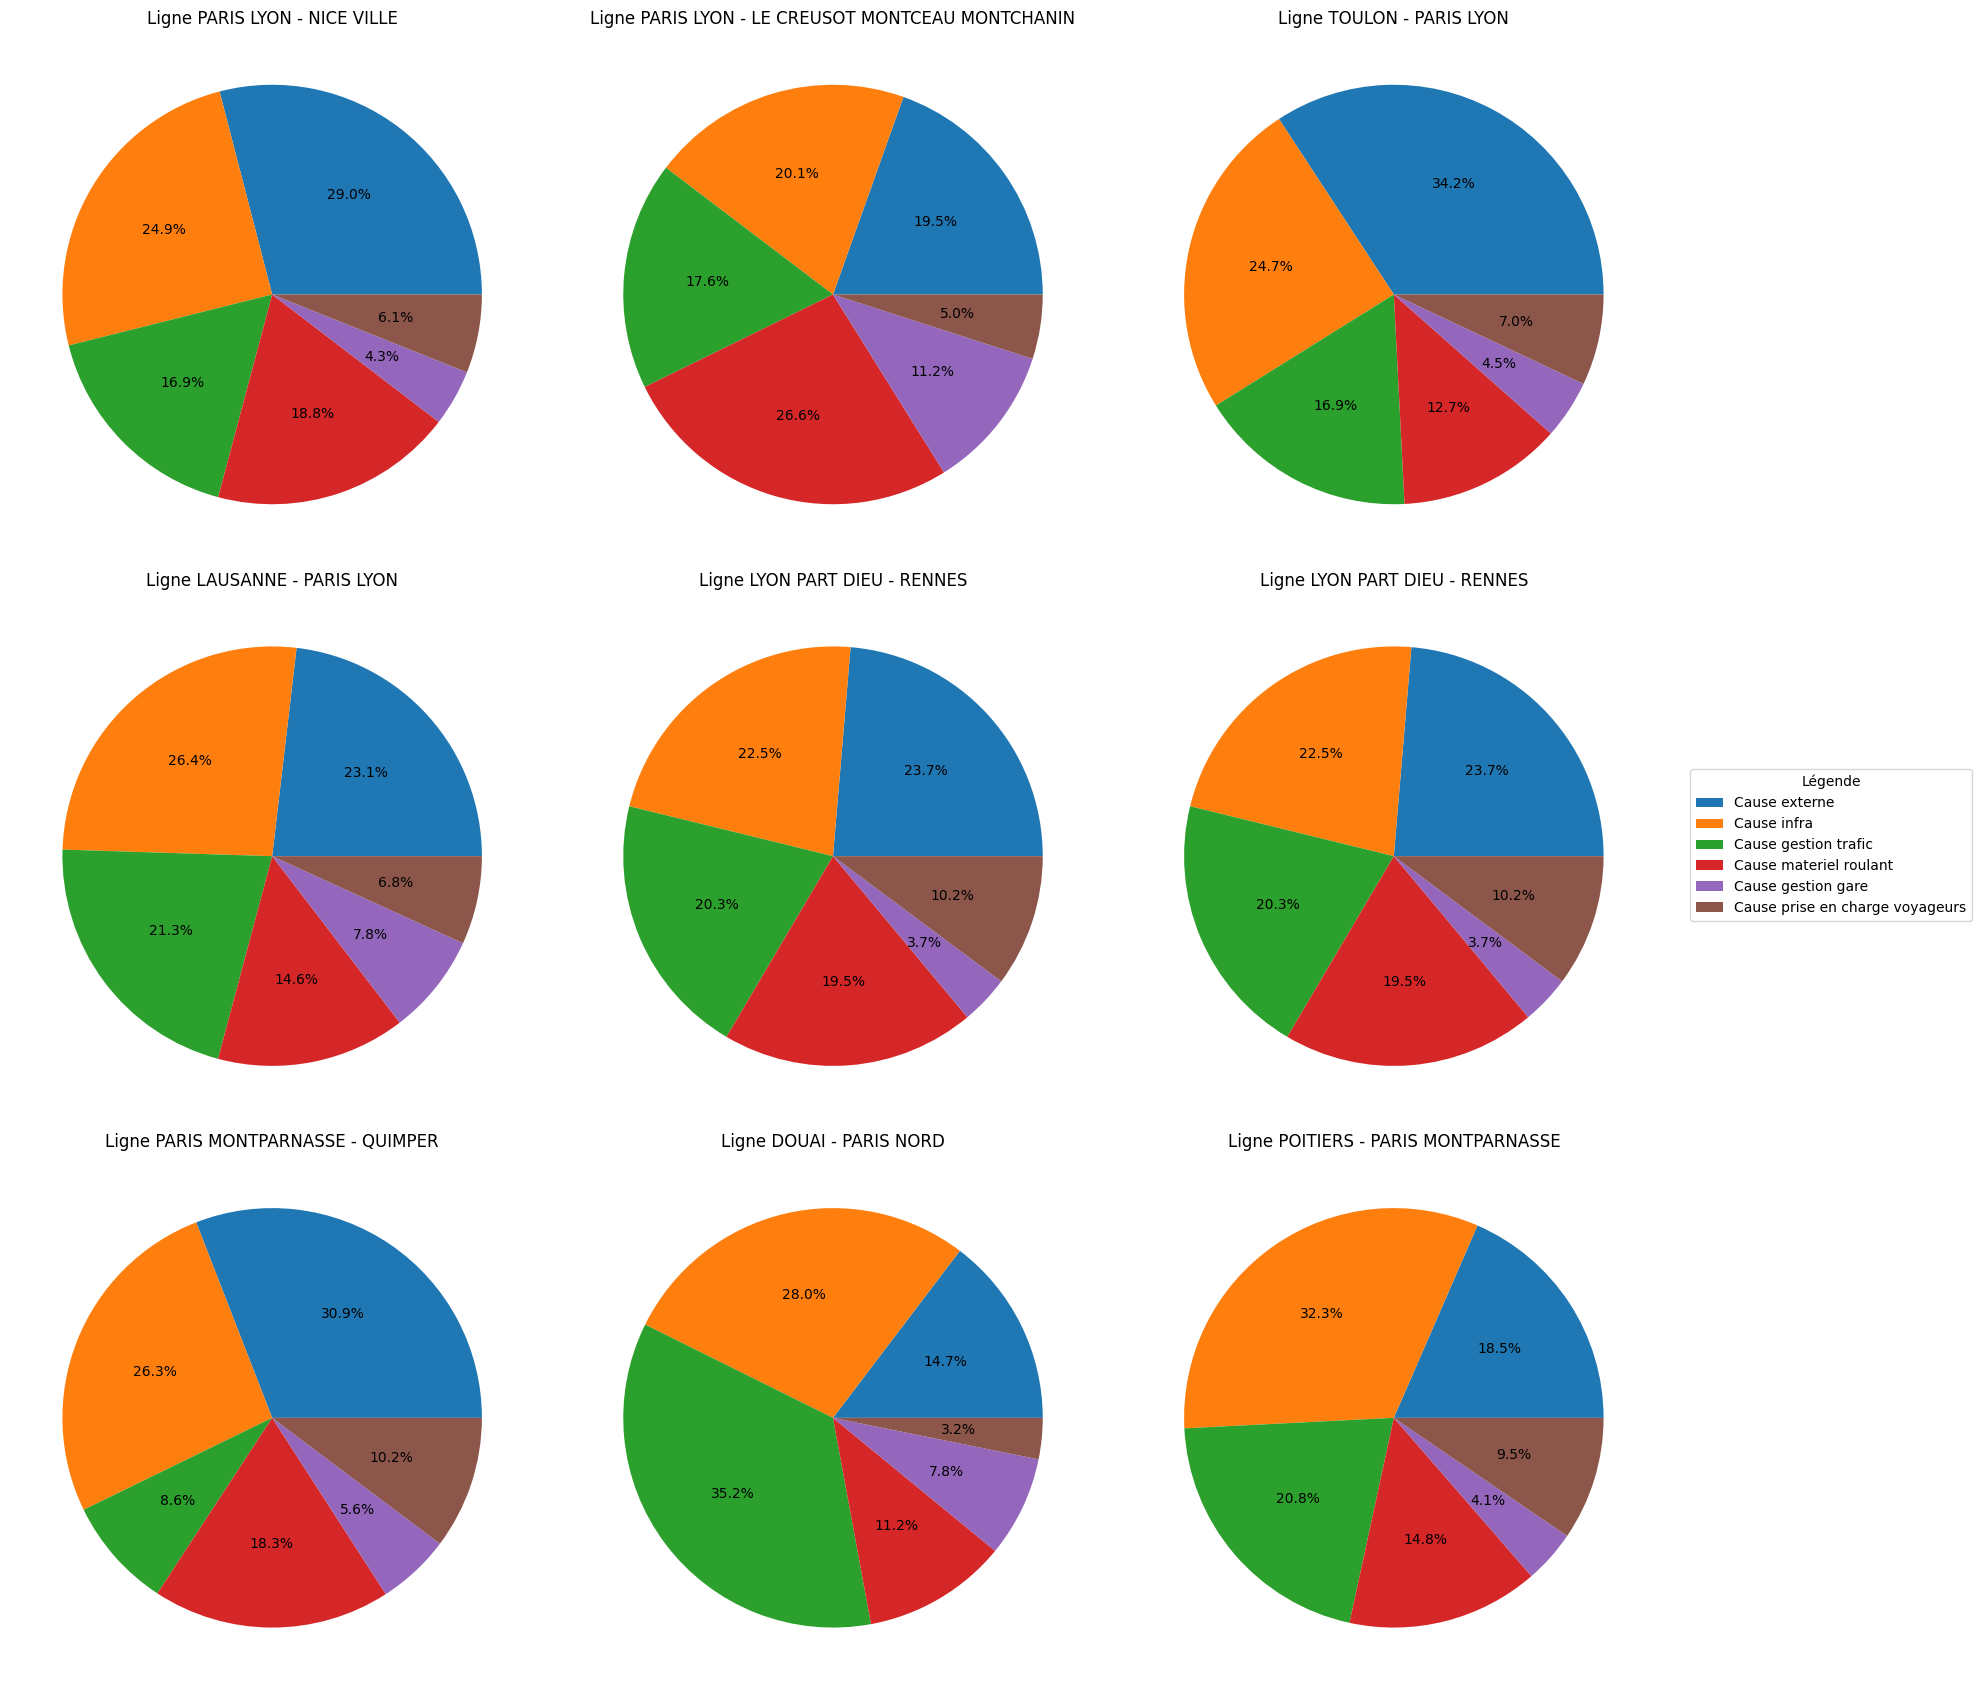

In [7]:
## Analyse par ligne et par cause
df_base['ligne'] = df_base['gare_depart']+ ' - ' + df_base['gare_arrivee']
df_base_groupby_ligne = df_base.groupby("ligne").agg(
    Cause_externe = ("prct_cause_externe",'mean'),
    Cause_infra = ("prct_cause_infra",'mean'),
    Cause_gestion_trafic = ("prct_cause_gestion_trafic",'mean'),
    Cause_materiel_roulant = ("prct_cause_materiel_roulant",'mean'),
    Cause_gestion_gare = ("prct_cause_gestion_gare",'mean'),
    Cause_prise_en_charge_voyageurs = ("prct_cause_prise_en_charge_voyageurs",'mean')
)


# Créez une liste pour stocker les 9 lignes sélectionnées
selected_lines = []

# Sélectionnez 9 lignes aléatoirement
for _ in range(9):
    selected_line = df_base_groupby_ligne.sample(1)
    selected_line = selected_line.reset_index()
    selected_lines.append(selected_line)

# Créez une grille de sous-graphiques de 3 lignes par 3 colonnes
fig, axes = plt.subplots(3, 3, figsize=(17, 17))


# Créez des graphiques pie pour chaque ligne sélectionnée
for i, selected_line in enumerate(selected_lines):
    # Réorganisez les données pour les rendre adaptées à un pie chart
    ligne_name = selected_line.ligne.values[0]
    selected_line = selected_line.drop(columns=['ligne']).T
    selected_line.columns = ['Pourcentage']

    # Créez un graphe pie
    ax = axes[i // 3, i % 3]
    wedges, texts, autotexts = ax.pie(selected_line['Pourcentage'], labels=[''] * len(selected_line.index), autopct='%1.1f%%')
    ax.set_title(f"Ligne {ligne_name}")

# Ajustez l'espacement entre les graphiques
plt.tight_layout()

# Créez une légende commune en dehors de la grille
legend_labels = ['Cause externe', 'Cause infra', 'Cause gestion trafic', 'Cause materiel roulant', 'Cause gestion gare', 'Cause prise en charge voyageurs']
fig.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), title="Légende")


# Affichez les graphiques
plt.show()
